# PCA on weather & time features for power-outage modeling (2014–2020)

**Goal**: Use PCA to 
    (i) understand dominant patterns in weather/time
    (ii) compress them into a small number of orthogonal factors ("PCs")
    (iii) export those PCs for downstream modeling (probability of outage)

**What this is not**: We are not training a predictive model here. We’re purely just preparing and inspecting features

**Key questions**:

* How many components (k) are enough to summarize weather/time drivers?

* What do the first PCs "mean" (which features load heavily)?

* Do PCs separate regimes across season, region, or state?

**Leakage note**: For anything that will flow into a model evaluation, fit scaler + PCA on training years only (e.g., 2014–2018) and transform 2019 + 2020 later

## 0. Load Neccessary Libraries

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

## 1. Data Loading

In [39]:
# Path to processed data directory
PROCESSED_DATA = "../../data/processed"

# Load the integrated processed dataset
dt = pd.read_csv(f"{PROCESSED_DATA}/integrated_dataset.csv")

# Sneak peak of the data
dt.head(20)

,fips_code,date,prcp,tmax,tmin,outage_occurred,customers_out,county,state,run_start_time,year,month,day_of_week,day_name,season,outage_hour,region
0,1001,2014-01-01,0.00,7.92,3.12,0,0,Autauga,Alabama,NaN,2014,1,2,Wednesday,Winter,NaN,Southeast
1,1001,2014-01-02,7.54,9.14,4.07,0,0,Autauga,Alabama,NaN,2014,1,3,Thursday,Winter,NaN,Southeast
2,1001,2014-01-03,1.41,12.62,-4.65,0,0,Autauga,Alabama,NaN,2014,1,4,Friday,Winter,NaN,Southeast
3,1001,2014-01-04,0.00,4.46,-5.44,0,0,Autauga,Alabama,NaN,2014,1,5,Saturday,Winter,NaN,Southeast
4,1001,2014-01-05,0.00,9.72,-4.71,0,0,Autauga,Alabama,NaN,2014,1,6,Sunday,Winter,NaN,Southeast
5,1001,2014-01-06,2.39,15.71,-3.26,0,0,Autauga,Alabama,NaN,2014,1,0,Monday,Winter,NaN,Southeast
6,1001,2014-01-07,0.00,-0.88,-11.17,0,0,Autauga,Alabama,NaN,2014,1,1,Tuesday,Winter,NaN,Southeast
7,1001,2014-01-08,0.00,-1.97,-11.40,0,0,Autauga,Alabama,NaN,2014,1,2,Wednesday,Winter,NaN,Southeast
8,1001,2014-01-09,0.00,6.69,-8.77,0,0,Autauga,Alabama,NaN,2014,1,3,Thursday,Winter,NaN,Southeast
9,1001,2014-01-10,3.90,10.84,-1.10,0,0,Autauga,Alabama,NaN,2014,1,4,Friday,Winter,NaN,Southeast


In [40]:
# Data shape
dt.shape

(3976135, 17)

In [41]:
# Different columns in dt
dt.columns

Index(['fips_code', 'date', 'prcp', 'tmax', 'tmin', 'outage_occurred',
       'customers_out', 'county', 'state', 'run_start_time', 'year', 'month',
       'day_of_week', 'day_name', 'season', 'outage_hour', 'region'],
      dtype='object')

In [42]:
# Number of missing values in each column
dt.isna().sum()

fips_code                0
date                     0
prcp                     0
tmax                     0
tmin                     0
outage_occurred          0
customers_out            0
county                   0
state                    0
run_start_time     1991833
year                     0
month                    0
day_of_week              0
day_name                 0
season                   0
outage_hour        1991833
region                   0
dtype: int64

**Data Scope & Columns Summary**

We have daily county-level records with:

* *Weather numeric*: `prcp`, `tmax`, `tmin`

* *Time-of-*: `month`, `day_of_week`, `outage_hour` (we will encode these cyclically)

* *Categorical context*: `region`, `state`, `season` (kept outside PCA for Option A; optionally included in Option B)

* *Targets*: `outage_occurred`, `customers_out` (never used in PCA)

* *IDs/dates*: `fips_code`, `county`, `date`, `run_start_time`, `year`, `day_name` (not used in PCA)

## 2. Train/Validation/Test Split

Here, we first split our dataset by time (fit on < 2019 and hold out 2019 & 2020 to transform later). Then, we implement cyclic encodings for `month` and `day_of_week`so distances respect the wrap-around (Dec ~ Jan, Sun ~ Mon). Notice that, while we do want to include `outage_hour`, there is a large number of missing values in such column and thus it will not work in PCA. So, we will exclude this out for the moment.

In [43]:
# Ensure we have correct datatype for date and year columns
dt["date"] = pd.to_datetime(dt["date"])
dt["year"] = dt["date"].dt.year
TARGET = "outage_occurred"

train = dt[dt["year"] <= 2018]      # Years in range 2014-2018
test  = dt[dt["year"] >= 2019]      # Include 2019 & 2020

X_train, y_train = train.drop(columns=[TARGET]), train[TARGET]
X_test,  y_test  = test.drop(columns=[TARGET]), test[TARGET]

## 3. PCA Implementation

**What to look for**

* *Scree/cumulative EV:* How many PCs explain 90–95% of variance?

* *Reconstruction error curve*: Does error plateau at a small k?

* *Loadings*: Which numeric/time encodings and which category levels drive PC1–PCk?

* *PC scatter (color by season/region)*: Do we see separation of regimes?

* *Stability/drift*: Do early vs late PCs span similar subspaces?

### a. PCA on Numeric + Cyclic Time Only

**Purpose:** Create principal components that summarize **weather + time** signals *without* mixing in category one-hots. Categories like `region/state/season` can still be used for **coloring/stratifying** plots or later in a predictive model.

- **Numeric used in PCA:** `prcp, tmax, tmin`
- **Cyclic encodings added:** `month_sin/cos`, `day_of_week_sin/cos`
- **Categoricals:** `region, state, season` (kept **out** of this version of PCA, will use for color plots)
- **Excluded from PCA:** targets and IDs/dates (`outage_occurred, customers_out, fips_code, county, date, run_start_time, year, day_name`)

**Note:** Here, we can't use `outage_hour` since there are missing values in such column.

In [44]:
# Numerical column in the dataset
num_cols= ["prcp", "tmax", "tmin", "month", "day_of_week"]

In [45]:
def _cyclic_pair(z, period, zero_based=True):
    z = np.asarray(z)
    if not zero_based:
        z = z - 1
    theta = 2 * np.pi * (z % period) / period
    return np.sin(theta), np.cos(theta)

In [46]:
def make_numeric_with_cycles(df_part: pd.DataFrame) -> pd.DataFrame:
    X = pd.DataFrame(index=df_part.index)
    X["prcp"] = df_part["prcp"].astype(float)
    X["tmax"] = df_part["tmax"].astype(float)
    X["tmin"] = df_part["tmin"].astype(float)

    mmin, mmax = df_part["month"].min(), df_part["month"].max()
    month_zero_based = not (mmin >= 1 and mmax <= 12)
    ms, mc = _cyclic_pair(df_part["month"], 12, zero_based=month_zero_based)
    X["month_sin"], X["month_cos"] = ms, mc

    dmin, dmax = df_part["day_of_week"].min(), df_part["day_of_week"].max()
    dow_zero_based = not (dmin >= 1 and dmax <= 7)
    ds, dc = _cyclic_pair(df_part["day_of_week"], 7, zero_based=dow_zero_based)
    X["dow_sin"], X["dow_cos"] = ds, dc

    return X

In [47]:
# Make the train/test set numeric with cycle
X_train_num1 = make_numeric_with_cycles(X_train[num_cols])
X_test_num1  = make_numeric_with_cycles(X_test[num_cols])

print("Numeric and Cyclic Shapes -> train:", X_train_num1.shape, "| test:", X_test_num1.shape)

Numeric and Cyclic Shapes -> train: (2839430, 7) | test: (1136705, 7)


In [48]:
# Standard scale the variable in the train set
scaler1 = StandardScaler(with_mean=True, with_std=True).fit(X_train_num1)
X_train_std1 = scaler1.transform(X_train_num1)

In [49]:
# Fit PCA
pca1 = PCA(n_components=None, random_state=42).fit(X_train_std1)
evr1 = pca1.explained_variance_ratio_
c_evr1 = evr1.cumsum()

# Explain variance
print("EVR (first 10):", np.round(evr1[:10], 3))
print("CumEV (first 10):", np.round(c_evr1[:10], 3))

EVR (first 10): [0.379 0.145 0.143 0.143 0.14  0.042 0.008]
CumEV (first 10): [0.379 0.524 0.667 0.81  0.95  0.992 1.   ]


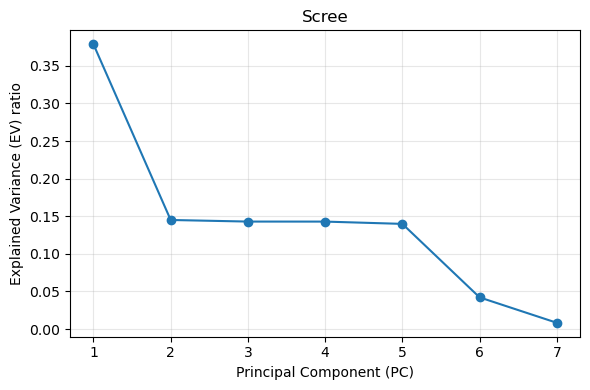

In [50]:
# Scree Plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(evr1)+1), evr1, marker="o")
plt.xlabel("Principal Component (PC)")
plt.ylabel("Explained Variance (EV) ratio")
plt.title("Scree")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

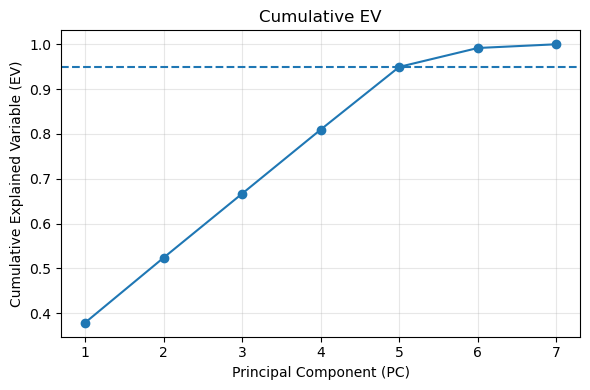

In [51]:
# Cumulative EV plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(evr1)+1), evr1.cumsum(), marker="o")
plt.axhline(0.95, ls="--")
plt.xlabel("Principal Component (PC)")
plt.ylabel("Cumulative Explained Variable (EV)")
plt.title("Cumulative EV") 
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [52]:
# Define function to reconstruct error curve
def reconstruction_rmse_curve_A(X_std, max_k=30):
    max_k = int(min(max_k, X_std.shape[1]))
    errs = []
    for k in range(1, max_k+1):
        p = PCA(n_components=k, random_state=42).fit(X_std)
        Xhat = p.inverse_transform(p.transform(X_std))
        rmse = np.linalg.norm(Xhat - X_std) / np.sqrt(X_std.size)
        errs.append(rmse)
    return np.array(errs)

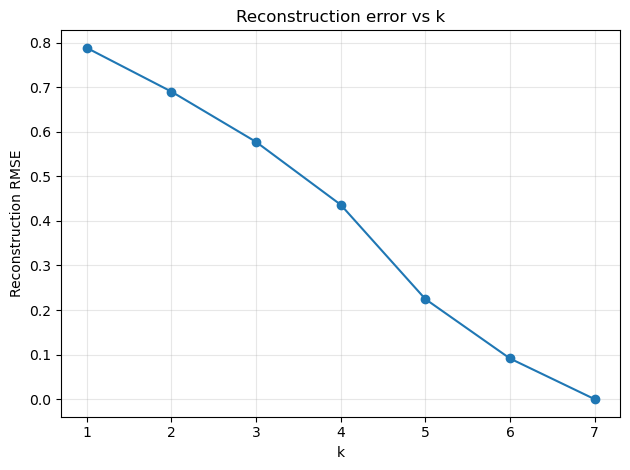

In [53]:
# Reconstruct the error curve
errs1 = reconstruction_rmse_curve_A(X_train_std1, max_k=min(30, X_train_std1.shape[1]))

plt.figure()
plt.plot(np.arange(1, len(errs1)+1), errs1, marker="o")
plt.xlabel("k")
plt.ylabel("Reconstruction RMSE")
plt.title("Reconstruction error vs k")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [54]:
# Choose k
k1 = int(np.searchsorted(c_evr1, 0.90) + 1)
print("Chosen k =", k1)

Chosen k = 5


In [55]:
# Fit PCA on standardized train features
pcaA = PCA(n_components=k1, random_state=42).fit(X_train_std1)

# Trainsform train/test
Z_train1 = pcaA.transform(X_train_std1)
Z_test1  = pcaA.transform(scaler1.transform(X_test_num1))

# Attach PC scores with an 'pc1' prefix to avoid name collisions
for i in range(k1):
    X_train[f"pc1{i+1}"] = Z_train1[:, i]
    X_test[f"pc{i+1}"]   = Z_test1[:, i]

print(f"Added PC columns to X_train/X_test: {k1} PCs")

Added PC columns to X_train/X_test: 5 PCs


In [56]:
# Sneak peek of current X_train
X_train.head(20)

,fips_code,date,prcp,tmax,tmin,customers_out,county,state,run_start_time,year,...,day_of_week,day_name,season,outage_hour,region,pc11,pc12,pc13,pc14,pc15
0,1001,2014-01-01,0.00,7.92,3.12,0,Autauga,Alabama,NaN,2014,...,2,Wednesday,Winter,NaN,Southeast,-1.469509,0.415281,1.215959,-0.237331,-0.605418
1,1001,2014-01-02,7.54,9.14,4.07,0,Autauga,Alabama,NaN,2014,...,3,Thursday,Winter,NaN,Southeast,-1.276391,0.344228,1.014400,-0.947444,0.768888
2,1001,2014-01-03,1.41,12.62,-4.65,0,Autauga,Alabama,NaN,2014,...,4,Friday,Winter,NaN,Southeast,-1.658476,-0.773586,0.045784,-0.954510,0.662027
3,1001,2014-01-04,0.00,4.46,-5.44,0,Autauga,Alabama,NaN,2014,...,5,Saturday,Winter,NaN,Southeast,-2.130951,-0.919975,-0.862078,-0.135597,0.613450
4,1001,2014-01-05,0.00,9.72,-4.71,0,Autauga,Alabama,NaN,2014,...,6,Sunday,Winter,NaN,Southeast,-1.814269,-0.418510,-1.082128,0.832275,0.093442
5,1001,2014-01-06,2.39,15.71,-3.26,0,Autauga,Alabama,NaN,2014,...,0,Monday,Winter,NaN,Southeast,-1.391823,0.467946,-0.432681,1.237016,-0.356747
6,1001,2014-01-07,0.00,-0.88,-11.17,0,Autauga,Alabama,NaN,2014,...,1,Tuesday,Winter,NaN,Southeast,-2.692400,0.703948,0.582728,0.750432,-0.837066
7,1001,2014-01-08,0.00,-1.97,-11.40,0,Autauga,Alabama,NaN,2014,...,2,Wednesday,Winter,NaN,Southeast,-2.766723,0.453196,1.208022,-0.243319,-0.582975
8,1001,2014-01-09,0.00,6.69,-8.77,0,Autauga,Alabama,NaN,2014,...,3,Thursday,Winter,NaN,Southeast,-2.194413,-0.266343,0.962083,-1.009766,0.005216
9,1001,2014-01-10,3.90,10.84,-1.10,0,Autauga,Alabama,NaN,2014,...,4,Friday,Winter,NaN,Southeast,-1.524503,-0.561833,0.065485,-0.931632,0.928278


We display top absolute loadings so you can see which **numeric/time** encodings dominate each PC.

In [57]:
# Loading
feature_names1 = X_train_num1.columns.tolist()

loading1 = pd.DataFrame(
    pcaA.components_.T,
    index=feature_names1,
    columns=[f"PC{i+1}" for i in range(k1)]
)

for j in range(k1):
    print(f"\nTop |loadings| for PC{j+1}:")
    disp = loading1.iloc[:, j].abs().sort_values(ascending=False).head(12)
    display(pd.DataFrame({"feature": disp.index, f"|PC{j+1}|": disp.values}))


Top |loadings| for PC1:


,feature,|PC1|
0,tmin,0.590889
1,tmax,0.588604
2,month_cos,0.542182
3,prcp,0.092251
4,month_sin,0.042896
5,dow_cos,0.006766
6,dow_sin,0.006158



Top |loadings| for PC2:


,feature,|PC2|
0,prcp,0.632249
1,month_sin,0.502832
2,dow_sin,0.488927
3,dow_cos,0.324767
4,tmax,0.045527
5,month_cos,0.028706
6,tmin,0.000671



Top |loadings| for PC3:


,feature,|PC3|
0,dow_sin,0.750712
1,month_sin,0.555658
2,dow_cos,0.350368
3,month_cos,0.054904
4,prcp,0.037743
5,tmin,0.015610
6,tmax,0.015335



Top |loadings| for PC4:


,feature,|PC4|
0,dow_cos,0.822560
1,month_sin,0.561327
2,month_cos,0.062065
3,prcp,0.050382
4,dow_sin,0.039219
5,tmax,0.014131
6,tmin,0.013401



Top |loadings| for PC5:


,feature,|PC5|
0,prcp,0.760389
1,dow_sin,0.442462
2,month_sin,0.338985
3,dow_cos,0.308307
4,month_cos,0.101049
5,tmax,0.071109
6,tmin,0.028371


/Users/amourtu1934/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


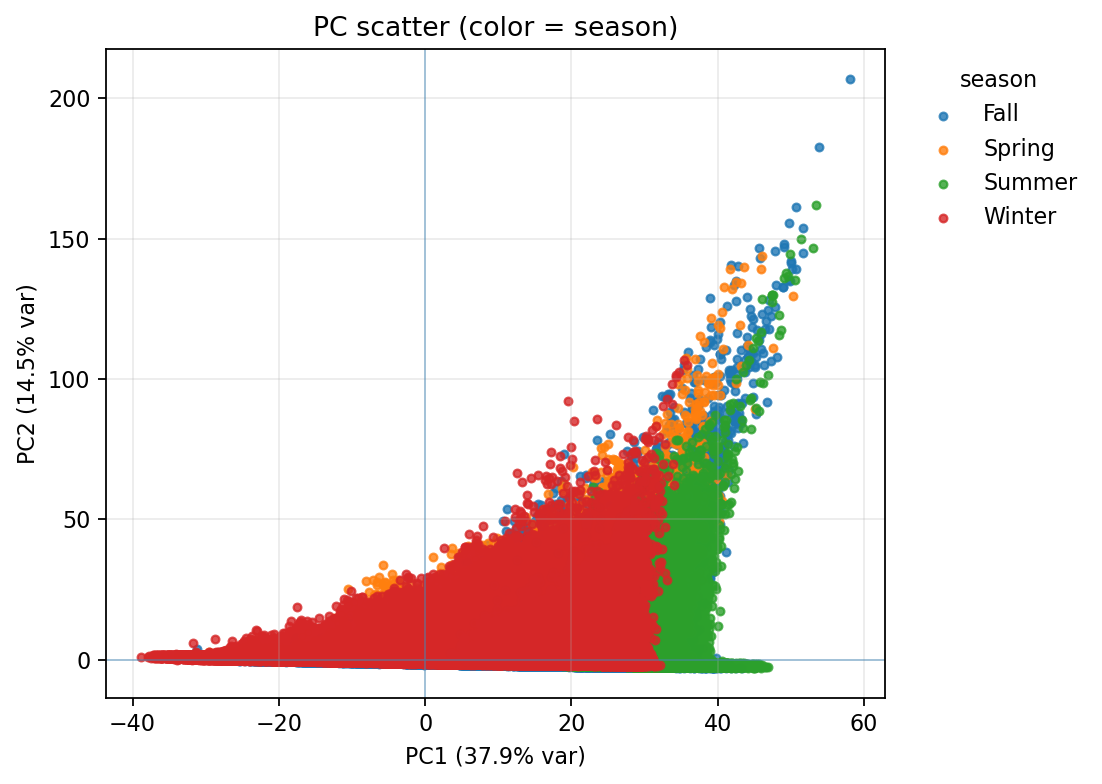

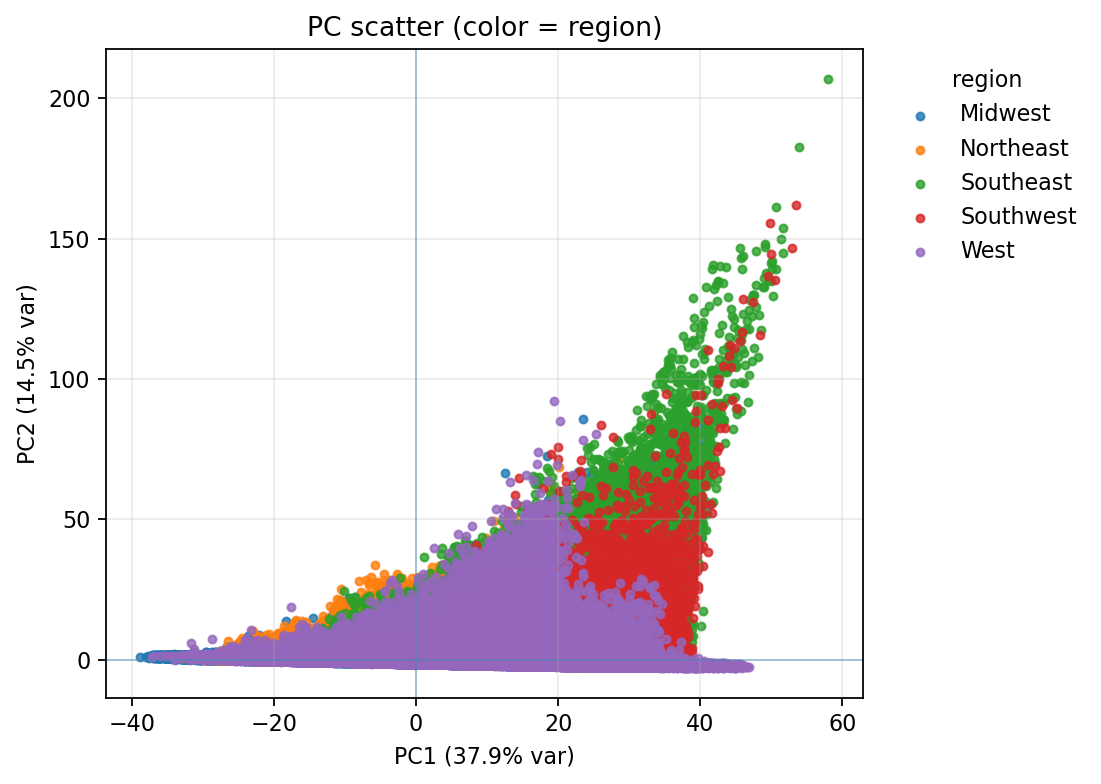

In [58]:
# Transform numeric training features to PC scores using the fitted pipeline
Z_train1 = pca1.transform(X_train_num1)
evr1 = (pca1.named_steps["pca"].explained_variance_ratio_
        if hasattr(pca1, "named_steps") and "pca" in pca1.named_steps
        else getattr(pca1, "explained_variance_ratio_", None))

hue_cols = ['season', 'region'] # 'state' is a lot
for hue in hue_cols:
    # Determine category order for consistent legend
    cats = pd.Categorical(train[hue]).categories

    plt.figure(figsize=(7, 5), dpi=160)

    # Plot each category separately to get a clean legend
    for cat in cats:
        m = (train[hue] == cat).to_numpy()
        plt.scatter(
            Z_train1[m, 0], Z_train1[m, 1],
            s=12, alpha=0.8, label=str(cat)
        )

    # Axes helpers
    plt.axhline(0, lw=0.8, alpha=0.4)
    plt.axvline(0, lw=0.8, alpha=0.4)
    plt.grid(True, alpha=0.25)

    # Show explained variance in axis labels
    if len(evr1) >= 2:
        plt.xlabel(f"PC1 ({evr1[0]*100:.1f}% var)")
        plt.ylabel(f"PC2 ({evr1[1]*100:.1f}% var)")
    else:
        plt.xlabel("PC1")
        plt.ylabel("PC2")

    plt.title(f"PC scatter (color = {hue})")

    # Legend outside the plot
    plt.legend(title=hue, frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

#### Findings: Option A — PCA on **Numeric + Cyclic Time** (no categoricals)

**What went into PCA**

* Continuous weather: `prcp, tmax, tmin`
* Cyclic encodings: `month_sin, month_cos, dow_sin, dow_cos`
* Shape check: train had 7 columns after encoding (`(2,839,430 × 7)` reported).

**Explained variance & dimensionality**

* EVR (first 7): **[0.379, 0.145, 0.143, 0.143, 0.140, 0.042, 0.008]**
* Cumulative EV: **[0.379, 0.524, 0.667, 0.810, 0.950, 0.992, 1.000]**
* Chosen dimensionality: **k = 5** (≥90% EV; actually ~95% by 5 PCs).
* Interpretation: after ~5 factors, marginal gains are tiny; the reconstruction-error curve plateaus accordingly (you computed and plotted it).

**What each PC is capturing (from top |loading| features)**

* **PC1 (~38% EV): annual temperature level / seasonality**

  * Top |loads|: `tmin, tmax, month_cos` (all large), with small `prcp` and very small weekly terms.
  * Read: a *temperature magnitude + annual phase (cos)* axis; warmer vs colder seasons drive the dominant variance.

* **PC2 (~14.5% EV): precipitation + weak weekly/annual mix**

  * Top |loads|: `prcp` (strong), then `month_sin`, `dow_sin`, `dow_cos`.
  * Read: a *precipitation intensity* factor that also co-moves a bit with season/week rhythm.

* **PC3 (~14.3% EV): weekly cycle (sine phase) with annual sine**

  * Top |loads|: `dow_sin`, `month_sin`, then `dow_cos`.
  * Read: the *day-of-week cycle* (sine phase) plus some annual sine component.

* **PC4 (~14.3% EV): weekly cycle (cos phase) with annual sine**

  * Top |loads|: `dow_cos`, `month_sin` (smaller contributions from `month_cos`, `prcp`).
  * Read: the *orthogonal weekly phase* to PC3 (cosine), again with mild annual sine.

* **PC5 (~14.0% EV): a second precipitation/weekly blend**

  * Top |loads|: `prcp` (very strong), then `dow_sin`, `month_sin`, `dow_cos`.
  * Read: residual *precipitation structure* not captured by PC2, entangled with weekly timing.

**Takeaways for Option A**

* **Interpretability is clean**: the first factor is unequivocally “temperature/season,” the next two are essentially the **weekly cycle** (two orthogonal phases), and precipitation shows up as **two directions** (PC2 & PC5), which is common when an effect co-varies with multiple rhythms.
* **Compact representation**: **5 PCs ~ 95% EV** gives us an orthogonal basis that keeps most weather/time signal while being small enough to drop into downstream models.
* **If the downstream model is sensitive to linear collinearity**, these PCs are a safer, lower-dimensional substitute for the raw weather/time features.


### b. PCA with Numeric + Categorical

We now build a PCA that **includes categorical variables** (`season`, `region`, `state`) alongside the numeric features by
using a `ColumnTransformer` with a numeric pipeline (impute + scale) and a categorical pipeline (impute + one‑hot encode).
This lets PCA account for variation attributable to these categories.

In [81]:
# Numerical + categorical columns in the dataset
num_cols    = ["prcp", "tmax", "tmin", "month", "day_of_week"]
cat_cols    = ["region","season"]

In [82]:
# Make the train/test set numeric with cycle
X_train_num2 = make_numeric_with_cycles(X_train[num_cols])
X_test_num2  = make_numeric_with_cycles(X_test[num_cols])

print("Numeric and Cyclic Shapes -> train:", X_train_num2.shape, "| test:", X_test_num2.shape)

Numeric and Cyclic Shapes -> train: (2839430, 7) | test: (1136705, 7)


In [83]:
# One-hot for categories (fitted on train)
onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False).fit(X_train[cat_cols])
X_train_cat = pd.DataFrame(
    onehot.transform(X_train[cat_cols]),
    index=X_train.index,
    columns=onehot.get_feature_names_out(cat_cols)
)

X_test_cat = pd.DataFrame(
    onehot.transform(X_test[cat_cols]),
    index=X_test.index,
    columns=onehot.get_feature_names_out(cat_cols)
)

# Print out metadata shapes
print("Categorical One-Hot Shapes -> train:", X_train_cat.shape, "| test:", X_test_cat.shape)

Categorical One-Hot Shapes -> train: (2839430, 9) | test: (1136705, 9)


In [84]:
# Sneak peak of combined numeric + categorical features
X_train_cat.head(20)

,region_Midwest,region_Northeast,region_Southeast,region_Southwest,region_West,season_Fall,season_Spring,season_Summer,season_Winter
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [85]:
# Standard scale numeric + categorical features in the train set
scaler2 = StandardScaler(with_mean=True, with_std=True).fit(pd.concat([X_train_num2, X_train_cat], axis=1))
X_train_std2 = scaler2.transform(pd.concat([X_train_num2, X_train_cat], axis=1))

In [86]:
# Fit PCA
pca2 = PCA(n_components=None, random_state=42).fit(X_train_std2)
evr2 = pca2.explained_variance_ratio_
c_evr2 = evr2.cumsum()

# Explain variance
print("EVR (first 10):", np.round(evr2[:10], 3))
print("CumEV (first 10):", np.round(c_evr2[:10], 3))

EVR (first 10): [0.233 0.14  0.101 0.083 0.081 0.073 0.068 0.063 0.063 0.06 ]
CumEV (first 10): [0.233 0.372 0.473 0.556 0.637 0.71  0.778 0.841 0.903 0.963]


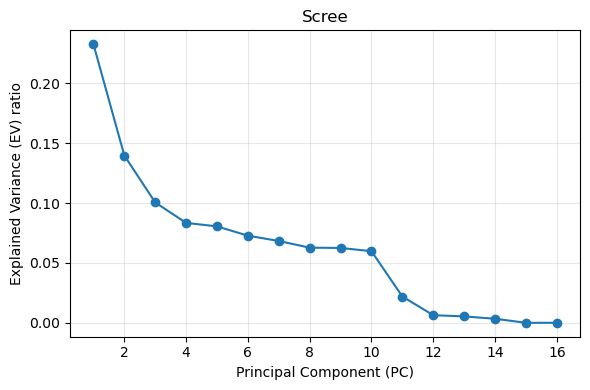

In [87]:
# Scree Plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(evr2)+1), evr2, marker="o")
plt.xlabel("Principal Component (PC)")
plt.ylabel("Explained Variance (EV) ratio")
plt.title("Scree")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

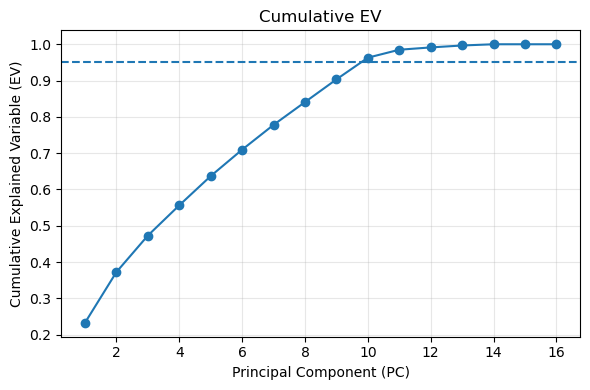

In [88]:
# Cumulative EV plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(evr2)+1), evr2.cumsum(), marker="o")
plt.axhline(0.95, ls="--")
plt.xlabel("Principal Component (PC)")
plt.ylabel("Cumulative Explained Variable (EV)")
plt.title("Cumulative EV")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [89]:
# Define function to reconstruct error curve
def reconstruction_rmse_curve_B(X_std, max_k=30):
    max_k = int(min(max_k, X_std.shape[1]))
    errs = []
    for k in range(1, max_k+1):
        p = PCA(n_components=k, random_state=42).fit(X_std)
        Xhat = p.inverse_transform(p.transform(X_std))
        rmse = np.linalg.norm(Xhat - X_std) / np.sqrt(X_std.size)
        errs.append(rmse)
    return np.array(errs)

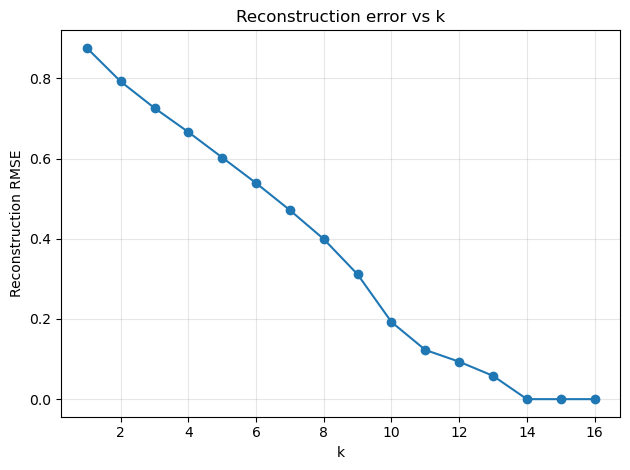

In [90]:
# Reconstruct the error curve
errs2 = reconstruction_rmse_curve_B(X_train_std2, max_k=min(30, X_train_std2.shape[1]))

plt.figure()
plt.plot(np.arange(1, len(errs2)+1), errs2, marker="o")
plt.xlabel("k")
plt.ylabel("Reconstruction RMSE")
plt.title("Reconstruction error vs k")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [91]:
# Choose k
k2 = int(np.searchsorted(c_evr2, 0.90) + 1)
print("Chosen k =", k2)

Chosen k = 9


In [92]:
# Fit PCA on standardized train features
pcaB = PCA(n_components=k2, random_state=42).fit(X_train_std2)

# Trainsform train/test
Z_train2 = pcaB.transform(X_train_std2)
Z_test2  = pcaB.transform(scaler2.transform(pd.concat([X_test_num2, X_test_cat], axis=1)))

# Attach PC scores with an 'pc2' prefix to avoid name collisions
for i in range(k2):
    X_train[f"pc2{i+1}"]  = Z_train2[:, i]
    X_test[f"pc2{i+1}"]   = Z_test2[:, i]

print(f"Added PC columns to X_train/X_test: {k2} PCs")

Added PC columns to X_train/X_test: 9 PCs


In [93]:
# Sneak peek of current X_train
X_train.head(20)

,fips_code,date,prcp,tmax,tmin,customers_out,county,state,run_start_time,year,...,pc234,pc235,pc236,pc237,pc238,pc239,pc240,pc241,pc242,pc243
0,1001,2014-01-01,0.00,7.92,3.12,0,Autauga,Alabama,NaN,2014,...,-0.007248,0.000482,-0.014404,0.001102,0.026961,-0.215413,0.043032,-0.110201,-0.031894,-0.037194
1,1001,2014-01-02,7.54,9.14,4.07,0,Autauga,Alabama,NaN,2014,...,-0.012028,0.005476,-0.014620,-0.000685,-0.003039,-0.195927,0.048038,-0.087011,-0.027504,0.024968
2,1001,2014-01-03,1.41,12.62,-4.65,0,Autauga,Alabama,NaN,2014,...,-0.018617,0.018323,-0.006572,-0.004662,-0.064088,-0.152087,0.059918,-0.070462,-0.027187,0.096481
3,1001,2014-01-04,0.00,4.46,-5.44,0,Autauga,Alabama,NaN,2014,...,-0.018232,0.019923,-0.006605,-0.006427,-0.071738,-0.144334,0.062957,-0.074535,-0.028235,0.106966
4,1001,2014-01-05,0.00,9.72,-4.71,0,Autauga,Alabama,NaN,2014,...,-0.013013,0.011571,-0.004709,-0.001917,-0.032412,-0.167141,0.056286,-0.100530,-0.035045,0.050980
5,1001,2014-01-06,2.39,15.71,-3.26,0,Autauga,Alabama,NaN,2014,...,-0.007367,-0.000792,-0.005688,0.004973,0.026982,-0.207260,0.044054,-0.126040,-0.040823,-0.029587
6,1001,2014-01-07,0.00,-0.88,-11.17,0,Autauga,Alabama,NaN,2014,...,-0.009855,-0.003197,-0.012057,0.007361,0.046613,-0.229916,0.036509,-0.122406,-0.038538,-0.065277
7,1001,2014-01-08,0.00,-1.97,-11.40,0,Autauga,Alabama,NaN,2014,...,-0.013194,0.001202,-0.013855,0.005211,0.026839,-0.220667,0.038960,-0.104516,-0.033523,-0.038554
8,1001,2014-01-09,0.00,6.69,-8.77,0,Autauga,Alabama,NaN,2014,...,-0.017085,0.011123,-0.010217,-0.000024,-0.024172,-0.184257,0.049780,-0.082115,-0.029011,0.033934
9,1001,2014-01-10,3.90,10.84,-1.10,0,Autauga,Alabama,NaN,2014,...,-0.017325,0.016572,-0.008788,-0.004947,-0.057122,-0.156660,0.059119,-0.071065,-0.026306,0.093750


We display top absolute loadings so you can see which **numeric/time** encodings dominate each PC.

In [94]:
# Loading
feature_names2 = pd.concat([X_train_num2, X_train_cat], axis=1).columns.tolist()

loading2 = pd.DataFrame(
    pcaB.components_.T,
    index=feature_names2,
    columns=[f"PC{i+1}" for i in range(k2)]
)

for j in range(k2):
    print(f"\nTop |loadings| for PC{j+1}:")
    disp = loading2.iloc[:, j].abs().sort_values(ascending=False).head(12)
    display(pd.DataFrame({"feature": disp.index, f"|PC{j+1}|": disp.values}))


Top |loadings| for PC1:


,feature,|PC1|
0,tmin,0.480758
1,tmax,0.480676
2,month_cos,0.470556
3,season_Winter,0.376004
4,season_Summer,0.366827
5,region_Southeast,0.138607
6,region_Midwest,0.099819
7,prcp,0.061638
8,region_West,0.045526
9,month_sin,0.036945



Top |loadings| for PC2:


,feature,|PC2|
0,month_sin,0.647122
1,season_Spring,0.539442
2,season_Fall,0.531774
3,month_cos,0.053730
4,season_Winter,0.049715
5,season_Summer,0.039788
6,prcp,0.014723
7,tmin,0.014270
8,tmax,0.009379
9,dow_sin,0.000749



Top |loadings| for PC3:


,feature,|PC3|
0,region_Southeast,0.678752
1,region_Midwest,0.584725
2,month_cos,0.237712
3,season_Summer,0.217188
4,season_Winter,0.195978
5,prcp,0.142957
6,tmin,0.111624
7,region_West,0.097631
8,tmax,0.094324
9,region_Northeast,0.049053



Top |loadings| for PC4:


,feature,|PC4|
0,season_Summer,0.508267
1,season_Fall,0.505246
2,season_Spring,0.492238
3,season_Winter,0.490607
4,prcp,0.033344
5,tmax,0.029580
6,region_Southeast,0.023071
7,region_Midwest,0.015344
8,region_Southwest,0.014624
9,month_cos,0.011070



Top |loadings| for PC5:


,feature,|PC5|
0,region_West,0.677683
1,region_Midwest,0.549941
2,region_Northeast,0.338888
3,region_Southeast,0.267729
4,prcp,0.149387
5,region_Southwest,0.136702
6,tmin,0.062050
7,month_cos,0.050251
8,season_Summer,0.049597
9,season_Winter,0.042286



Top |loadings| for PC6:


,feature,|PC6|
0,region_Northeast,0.831494
1,region_West,0.491203
2,prcp,0.205033
3,region_Southeast,0.118795
4,region_Midwest,0.087801
5,tmax,0.044783
6,season_Winter,0.018507
7,tmin,0.017872
8,dow_sin,0.015128
9,region_Southwest,0.013319



Top |loadings| for PC7:


,feature,|PC7|
0,region_Southwest,0.917876
1,region_West,0.239065
2,prcp,0.203075
3,region_Southeast,0.139808
4,region_Northeast,0.123062
5,tmax,0.086939
6,season_Winter,0.075583
7,month_cos,0.066801
8,season_Summer,0.049842
9,tmin,0.040836



Top |loadings| for PC8:


,feature,|PC8|
0,dow_sin,0.795667
1,dow_cos,0.518900
2,prcp,0.277827
3,region_Southwest,0.082785
4,region_West,0.072216
5,region_Southeast,0.066800
6,region_Northeast,0.056176
7,season_Summer,0.013497
8,month_cos,0.012387
9,tmin,0.011975



Top |loadings| for PC9:


,feature,|PC9|
0,dow_cos,0.835403
1,dow_sin,0.549444
2,prcp,0.011600
3,region_West,0.004702
4,region_Southeast,0.004565
5,tmax,0.003101
6,region_Southwest,0.002908
7,season_Summer,0.002881
8,region_Midwest,0.002192
9,season_Winter,0.001672


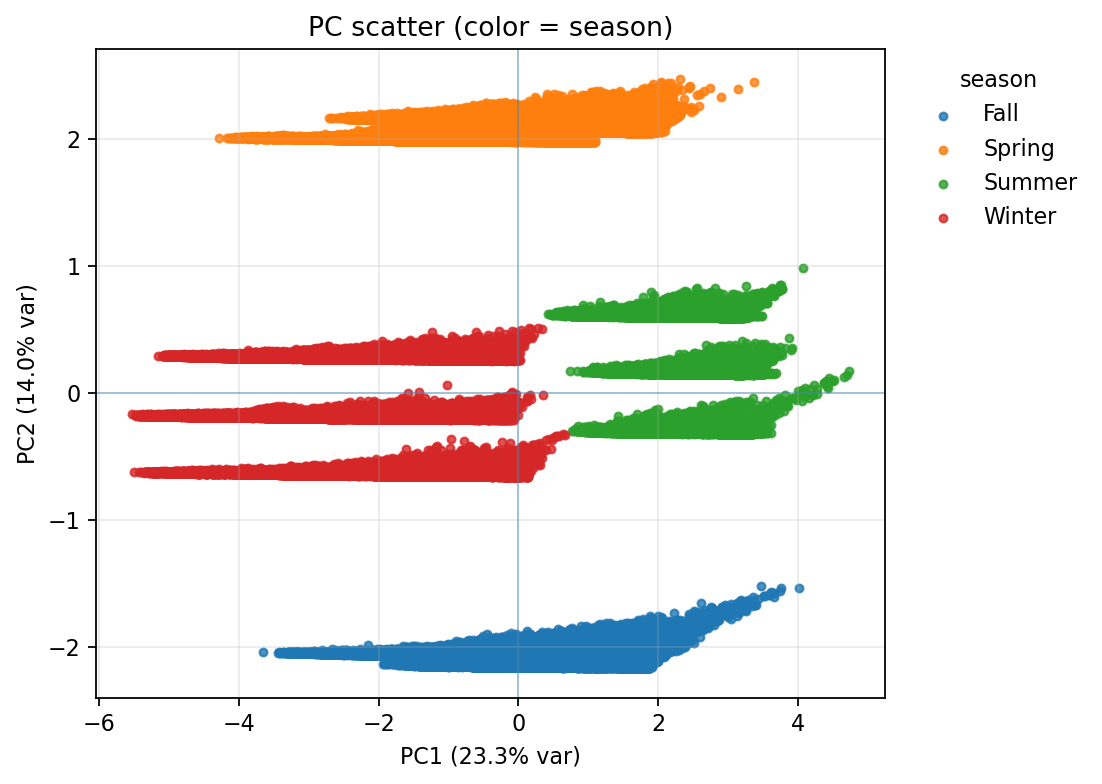

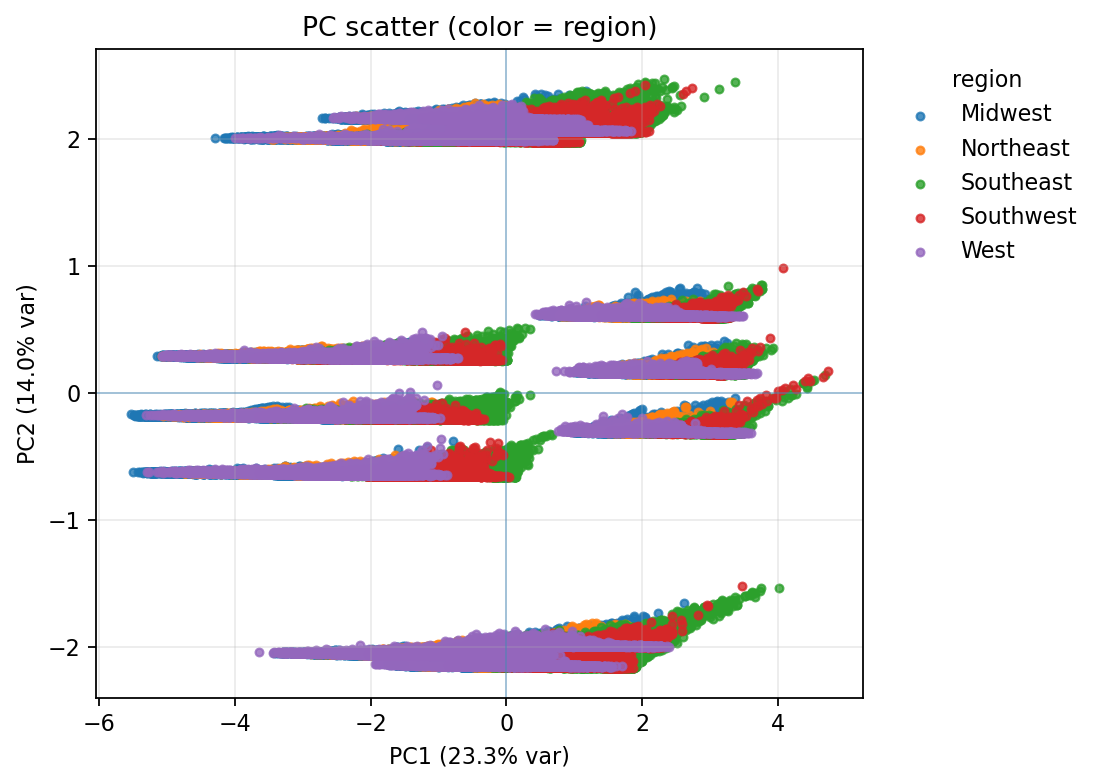

In [95]:
# Transform numeric + categorical training features to PC scores using the fitted pipeline
Z_train2 = pca2.transform(X_train_std2)
evr2 = (pca2.named_steps["pca"].explained_variance_ratio_
        if hasattr(pca2, "named_steps") and "pca" in pca2.named_steps
        else getattr(pca2, "explained_variance_ratio_", None))

hue_cols = ['season', 'region'] # 'state' is a lot
for hue in hue_cols:
    # Determine category order for consistent legend
    cats = pd.Categorical(train[hue]).categories

    plt.figure(figsize=(7, 5), dpi=160)

    # Plot each category separately to get a clean legend
    for cat in cats:
        m = (train[hue] == cat).to_numpy()
        plt.scatter(
            Z_train2[m, 0], Z_train2[m, 1],
            s=12, alpha=0.8, label=str(cat)
        )

    # Axes helpers
    plt.axhline(0, lw=0.8, alpha=0.4)
    plt.axvline(0, lw=0.8, alpha=0.4)
    plt.grid(True, alpha=0.25)

    # Show explained variance in axis labels
    if len(evr2) >= 2:
        plt.xlabel(f"PC1 ({evr2[0]*100:.1f}% var)")
        plt.ylabel(f"PC2 ({evr2[1]*100:.1f}% var)")
    else:
        plt.xlabel("PC1")
        plt.ylabel("PC2")

    plt.title(f"PC scatter (color = {hue})")

    # Legend outside the plot
    plt.legend(title=hue, frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

#### Findings: Option B — PCA on **Numeric + Cyclic Time + One-Hot Categoricals**

**What went into PCA**

* Same 7 numeric/cyclic features as Option A, **plus** one-hot encodings of `region` and `season`.
* One-hot shape reported: **9 categorical columns** (train), for a **total of 16** inputs to PCA.

**Explained variance & dimensionality**

* EVR (first 10): **[0.233, 0.140, 0.101, 0.083, 0.081, 0.073, 0.068, 0.063, 0.063, 0.060]**
* Cumulative EV (first 10): **[0.233, 0.372, 0.473, 0.556, 0.637, 0.710, 0.778, 0.841, 0.903, 0.963]**
* Chosen dimensionality: **k = 9** (≥90% EV).
* Interpretation: adding categoricals spreads variance across **more** factors. We need nearly twice as many PCs to reach the same EV threshold as Option A.

**What the first 9 PCs mean (from top |loading| features)**

* **PC1 (~23.3% EV): temperature/season level, now **blended** with categorical seasons**

  * Top |loads|: `tmin, tmax, month_cos` **and** `season_Winter`, `season_Summer`.
  * Read: Our former “temperature/annual” axis is now **mixed with season dummies**, i.e., categorical season labels are co-capturing annual temperature.

* **PC2 (~14.0% EV): annual *sine* + categorical spring/fall**

  * Top |loads|: `month_sin` with **`season_Spring` and `season_Fall`** strong.
  * Read: the *spring - fall* contrast is now largely **categorical**.

* **PC3 (~10.1% EV): regional identity (Southeast & Midwest) with mild seasonal/temperature**

  * Top |loads|: `region_Southeast`, `region_Midwest`; medium `month_cos`, `season_Summer/Winter`, plus smaller `prcp`, `tmin/tmax`.
  * Read: **regional clustering** dominates this direction.

* **PC4 (~8.3% EV): pure season block**

  * Top |loads|: `season_Summer`, `season_Fall`, `season_Spring`, `season_Winter` (all ~0.49–0.51).
  * Read: **season label identity** almost by itself.

* **PC5 (~8.1% EV): regional identity (West & Midwest)**

  * Top |loads|: `region_West`, `region_Midwest` (and some `region_Southeast`), small `prcp`.
  * Read: another **region partition**.

* **PC6 (~7.3% EV): regional identity (Northeast & West)**

  * Top |loads|: `region_Northeast`, then `region_West`; smaller `prcp`, category traces.
  * Read: continues the **region spectrum**.

* **PC7 (~6.8% EV): regional identity (Southwest)**

  * Top |loads|: `region_Southwest` (very strong), then `region_West`, small contributions elsewhere.
  * Read: isolates the **Southwest** contrast.

* **PC8 (~6.3% EV): weekly cycle (sine & cos) + a bit of precipitation**

  * Top |loads|: `dow_sin`, `dow_cos`, then `prcp` with small region/season traces.
  * Read: finally the **weekly rhythm** appears prominently again.

* **PC9 (~6.3% EV): the orthogonal weekly phase**

  * Top |loads|: `dow_cos`, `dow_sin` (the complementary phase), tiny others.
  * Read: completes the **weekly pair** (as in Option A, but pushed later by categoricals).

**Takeaways for Option B**

* **Categoricals dominate a lot of variance.** Several leading PCs are **mostly region/season identity** axes. This is mathematically correct—one-hot dummies are high-variance, mutually exclusive bits—but it can **dilute** the weather/time structure you were primarily trying to summarize with PCA.
* **Dimensionality needs to be larger (k ~ 9)** to reach 90% EV because you’re now explaining both **smooth** (weather/time) and **discrete** (region/season) structure.
* **Interpretability shifts**: early PCs now say “*this season/this region*” rather than “*this weekly/annual waveform or precipitation mode*.” If your goal is portable weather/time factors usable across groups, this might be less desirable.

### 4. Some Takeaways

Moving on from here, I think it would be better if we have some variable for region/season as separate fixed effects. Then, we would use option A, of which it gives us compact (~5d) and cleanly interpretable weather/time factors. We can also avoid PCs that are just "region = West" in diguise. 

Option B (add one-hot categoricals) needs ~9 PCs for ~90%, and early PCs are mostly region/season identity, which dilutes the weather/time signals.
